In [60]:
# Import libraries
import pandas as pd
import numpy as np
import math
!pip install cplex
import cplex
import matplotlib.pyplot as plt


# Strategies
 For strategies 3, 4, and 5 include mathematical formulation of optimization problem in report and/or in notebook

In [61]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [62]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    n = len(cur_prices)
    transaction_cost_rate = 0.005  # transaction cost rate 0.5%

    # calculate the portfolio value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init

    # buy at least 1 share for target x
    x_target = np.maximum(1, np.floor((portfolio_value / n) / cur_prices))

    # change of shares holding
    delta_x = x_target - x_init

    # buy and sell value
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # transaction cost
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate

    # cash account
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sure cash account > 0
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    # final holding
    x_optimal = x_init + delta_x

    return x_optimal, cash_optimal


In [63]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):

    n = len(cur_prices)  # number of shares
    transaction_cost_rate = 0.005

    # initialize CPLEX
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.QP)
    problem.set_log_stream(None)  # turn off others
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    # target variable: weights
    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function: minimize w^T Q w
    quad_expr = []
    for i in range(n):
        for j in range(n):
            if Q[i][j] != 0:
                quad_expr.append((w_names[i], w_names[j], Q[i][j]))

    for w1, w2, val in quad_expr:
        problem.objective.set_quadratic_coefficients(w1, w2, val)

    problem.objective.set_sense(problem.objective.sense.minimize)

    # weights sum to 1
    problem.linear_constraints.add(
        lin_expr=[[w_names, [1.0] * n]],
        senses=["E"],
        rhs=[1.0]
    )

    # solve
    problem.solve()
    w_optimal = np.array([problem.solution.get_values(w) for w in w_names])

    # new holding
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.maximum(1, np.floor((w_optimal * portfolio_value) / cur_prices))

    # use change of x to calculate transaction cost
    delta_x = x_target - x_init

    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # calculate transaction cost and cash account
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sure cash account > 0
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    # final holding
    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


In [64]:
def strat_max_return(x_init, cash_init, mu, Q, cur_prices):

    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # annualized mu and adjusted
    mu_annualized = (1 + mu) ** 252 - 1
    mu_adjusted = mu_annualized - 0.015
    mu_adjusted = mu_adjusted / np.max(np.abs(mu_adjusted))

    # initialize cplex
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.LP)  # linear programming
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function: maximize w^T mu_adjusted
    objective_coeffs = mu_adjusted.tolist()
    problem.objective.set_linear(list(zip(w_names, objective_coeffs)))
    problem.objective.set_sense(problem.objective.sense.maximize)

    # weights sum to 1
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    problem.solve()

    w_optimal = np.array([problem.solution.get_values(w) for w in w_names])

    # w_optimal in acceptable range
    w_optimal = np.clip(w_optimal, 0, 1)

    # calculate portfolio value and target x value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.maximum(1, np.floor((w_optimal * portfolio_value) / cur_prices))

    # transaction cost
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # transaction cost and cash account
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sur no negative cash
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


In [65]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, r_f=0.015):
    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # annulize and adjust. mu
    mu_annualized = (1 + mu) ** 252 - 1  # 252 trading days
    mu_adjusted = mu_annualized - r_f
    if np.all(mu_adjusted <= 0):
        mu_adjusted = mu_adjusted - np.min(mu_adjusted)

    # initialize cplex
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.QP) # Quadratic programming
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    # variables
    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function
    problem.objective.set_linear([(w_names[i], float(mu_adjusted[i])) for i in range(n)])
    problem.objective.set_sense(problem.objective.sense.maximize)

    # linear constraint 1
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    # constraint 2：w^T Q w ≤ 0.1
    Q_norm = Q / np.linalg.norm(Q, 'fro')
    quad_expr = [(w_names[i], w_names[j], float(Q_norm[i, j])) for i in range(n) for j in range(n) if abs(Q_norm[i, j]) > 1e-8]

    # quadratic constraints
    problem.quadratic_constraints.add(
        lin_expr=cplex.SparsePair(ind=[], val=[]),
        quad_expr=cplex.SparseTriple(
            ind1=[q[0] for q in quad_expr],
            ind2=[q[1] for q in quad_expr],
            val=[q[2] for q in quad_expr]
        ),
        sense="L",
        rhs=0.1,
        name="Sharpe_ratio_constraint"
    )

    # solve the optimization
    problem.solve()

    w_optimal = np.array(problem.solution.get_values(w_names))

    # calculate the portfolio value and target x value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.round((w_optimal * portfolio_value) / cur_prices)

    # calculate the transaction cost and the cash account
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sure no negative cash
    while cash_optimal < -1e-6 and np.any(delta_x > 0):
        buy_indices = np.where(delta_x > 0)[0]
        if len(buy_indices) == 0:
            break
        sorted_indices = buy_indices[np.argsort(-cur_prices[buy_indices])]

        for idx in sorted_indices:
            if cash_optimal >= 0:
                break
            if delta_x[idx] > 0:
                delta_x[idx] -= 1
                cash_optimal += cur_prices[idx] - cur_prices[idx] * transaction_cost_rate

    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


# Data loading and initialization of portfolios

In [66]:
# Input file
input_file_prices='adjclose_2020_2021.csv' # path to close_2020_2021 file

# Read data into a dataframe
df = pd.read_csv(input_file_prices)


In [67]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [68]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
if '2021' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
elif '2022' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2020)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [69]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio']

N_strat = len(strategy_functions)
N_strat = 1  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe]


Initial portfolio value = $ 1000016.96



# Running computations and printing results

In [70]:
# initialize portfolio information
N_strat = len(strategy_names)  # 5 strateegies
N_days = len(dates)  # days
N_periods = 12  # 12 rebalancing chances

# store data
portf_value = [np.zeros(N_days) for _ in range(N_strat)]
x = np.zeros((N_strat, N_periods), dtype=object)
cash = np.zeros((N_strat, N_periods))

# for all periods of rebalancing
for period in range(1, N_periods + 1):
    # year and month for the current period
    if '2020' in input_file_prices:
        if dates_array[0, 0] == 20:
            cur_year = 20 + math.floor(period / 7)
        else:
            cur_year = 2020 + math.floor(period / 7)
    elif '2021' in input_file_prices:
        if dates_array[0, 0] == 21:
            cur_year = 21 + math.floor(period / 7)
        else:
            cur_year = 2021 + math.floor(period / 7)

    cur_month = 2 * ((period - 1) % 6) + 1

    valid_days_start = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month))[0]
    valid_days_end = np.where((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1))[0]

    if len(valid_days_start) == 0 or len(valid_days_end) == 0:
        print(f"Skipping period {period} due to missing trading days.")
        continue

    day_ind_start = valid_days_start[0]
    day_ind_end = valid_days_end[-1]

    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

    # current price
    cur_prices = data_prices[day_ind_start, :]

    # for all strategies
    for strategy in range(N_strat):

        # current portfolio
        if period == 1:
            curr_positions = init_positions.copy()
            curr_cash = 0.0
            portf_value[strategy] = np.zeros(N_days)
        else:
            curr_positions = x[strategy, period - 2].copy()
            curr_cash = float(cash[strategy, period - 2])

        x_new, cash_new = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # make sure x_new` numpy,`cash_new` float
        x[strategy, period - 1] = np.array(x_new)
        cash[strategy, period - 1] = float(cash_new)

        # calculate portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end + 1, :], x_new) + cash_new
        portf_value[strategy][day_ind_start:day_ind_end + 1] = np.ravel(p_values)

        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(
            strategy_names[strategy],
            portf_value[strategy][day_ind_start],
            portf_value[strategy][day_ind_end],
            cash[strategy, period - 1]
        ))

    # mu and Q for the next period
    cur_returns = data_prices[day_ind_start + 1:day_ind_end + 1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    mu = np.mean(cur_returns, axis=0)
    Q = np.cov(cur_returns.T)



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990729.82, value end = $ 904015.58, cash account = $7.56
  Strategy "Minimum Variance Portfolio", value begin = $ 990212.13, value end = $ 906923.01, cash account = $0.33
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990067.38, value end = $ 917046.64, cash account = $9.90
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 989965.70, value end = $ 915914.50, cash account = $111.53

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 935621.22, value end = $ 918221.82, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 943969.98, value end = $ 890233.01, cash account = $554.53
  Strategy "Minimum Variance Portfolio", value begin = $ 938903.53, value end = $ 889899.06, cash account 

# Plot results

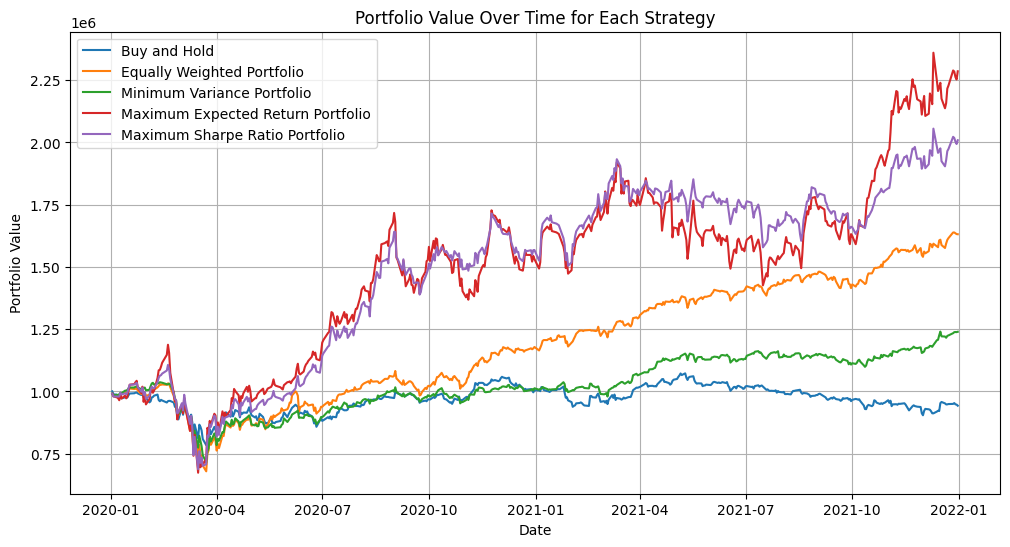

In [71]:
portf_value = np.array(portf_value)  # N_strat, N_days
dates = pd.to_datetime(dates)

# plot the lines
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates, portf_value[strategy].flatten(), label=strategy_names[strategy])

# format the graph
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time for Each Strategy")
plt.legend()
plt.grid(True)
plt.show()


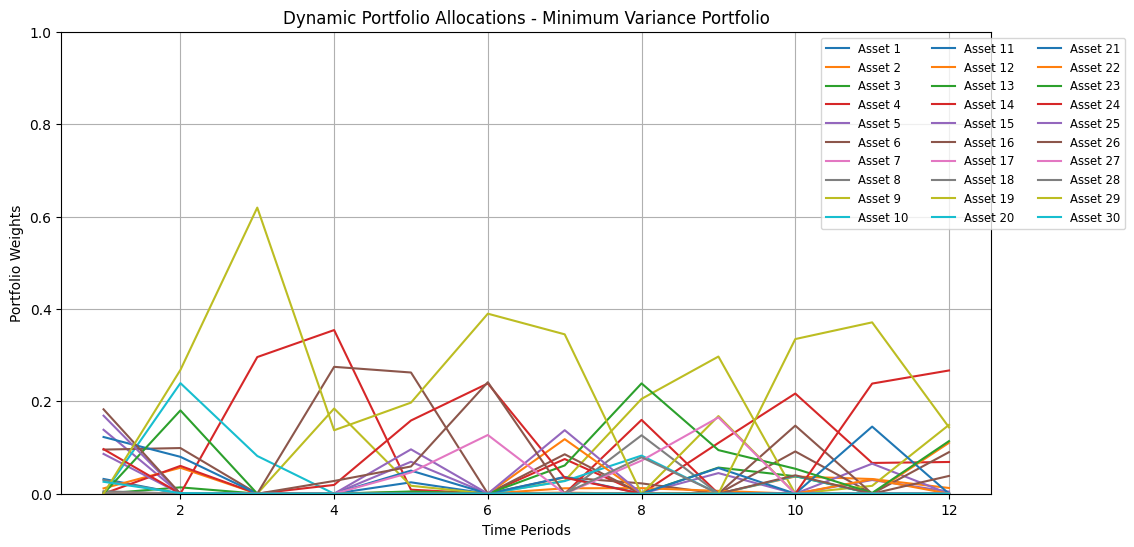

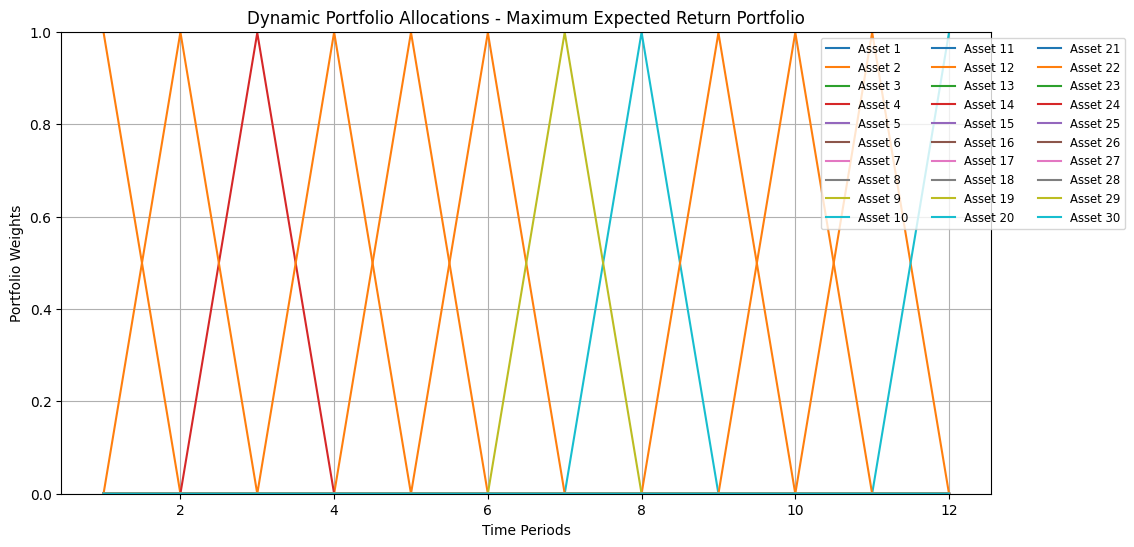

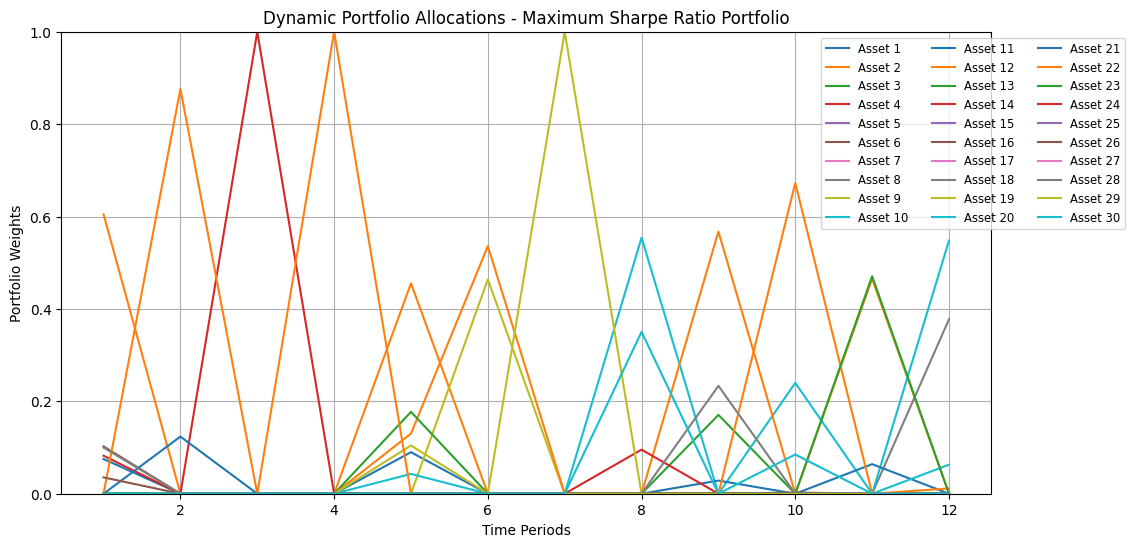

In [72]:
# for strategies 3, 4, 5
strategy_indices = [2, 3, 4]
strategy_labels = ["Minimum Variance Portfolio", "Maximum Expected Return Portfolio", "Maximum Sharpe Ratio Portfolio"]

num_assets = data_prices.shape[1]
time_periods = N_periods

# loop to plot the graphs
for i, strategy in enumerate(strategy_indices):
    plt.figure(figsize=(12, 6))

    portfolio_weights = np.zeros((time_periods, num_assets))

    for period in range(time_periods):
        if x[strategy, period] is not None:
            total_value = np.dot(data_prices[day_ind_start, :], x[strategy, period]) + cash[strategy, period]
            portfolio_weights[period, :] = (x[strategy, period] * data_prices[day_ind_start, :]) / total_value

    # plot the weights
    for asset in range(num_assets):
        plt.plot(range(1, time_periods + 1), portfolio_weights[:, asset], label=f'Asset {asset+1}')

    # format the graphs
    plt.xlabel("Time Periods")
    plt.ylabel("Portfolio Weights")
    plt.title(f"Dynamic Portfolio Allocations - {strategy_labels[i]}")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0), fontsize="small", ncol=3)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()


In [73]:
# Function to compute maximum drawdown
def max_drawdown(portfolio_values):
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_max) / cumulative_max
    return np.min(drawdowns)  # Minimum drawdown

# Function to compute Sharpe ratio
def sharpe_ratio(portfolio_values, risk_free_rate=0.015):
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = daily_returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns, ddof=1)

risk_measures = {}

for strategy, values in enumerate(portf_value):
    values = np.array(values).flatten()
    variance = np.var(np.diff(values) / values[:-1])
    max_dd = max_drawdown(values)
    sharpe = sharpe_ratio(values)

    risk_measures[strategy_names[strategy]] = {
        "Variance": variance,
        "Max Drawdown": max_dd,
        "Sharpe Ratio": sharpe
    }

# Print risk measures for each strategy
for strat, metrics in risk_measures.items():
    print(f"\nStrategy: {strat}")
    print(f"Variance: {metrics['Variance']:.6f}")
    print(f"Maximum Drawdown: {metrics['Max Drawdown']:.6f}")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.6f}")



Strategy: Buy and Hold
Variance: 0.000168
Maximum Drawdown: -0.215932
Sharpe Ratio: -0.007198

Strategy: Equally Weighted Portfolio
Variance: 0.000277
Maximum Drawdown: -0.342244
Sharpe Ratio: 0.064230

Strategy: Minimum Variance Portfolio
Variance: 0.000178
Maximum Drawdown: -0.311086
Sharpe Ratio: 0.035604

Strategy: Maximum Expected Return Portfolio
Variance: 0.000896
Maximum Drawdown: -0.432858
Sharpe Ratio: 0.068474

Strategy: Maximum Sharpe Ratio Portfolio
Variance: 0.000595
Maximum Drawdown: -0.378531
Sharpe Ratio: 0.067293


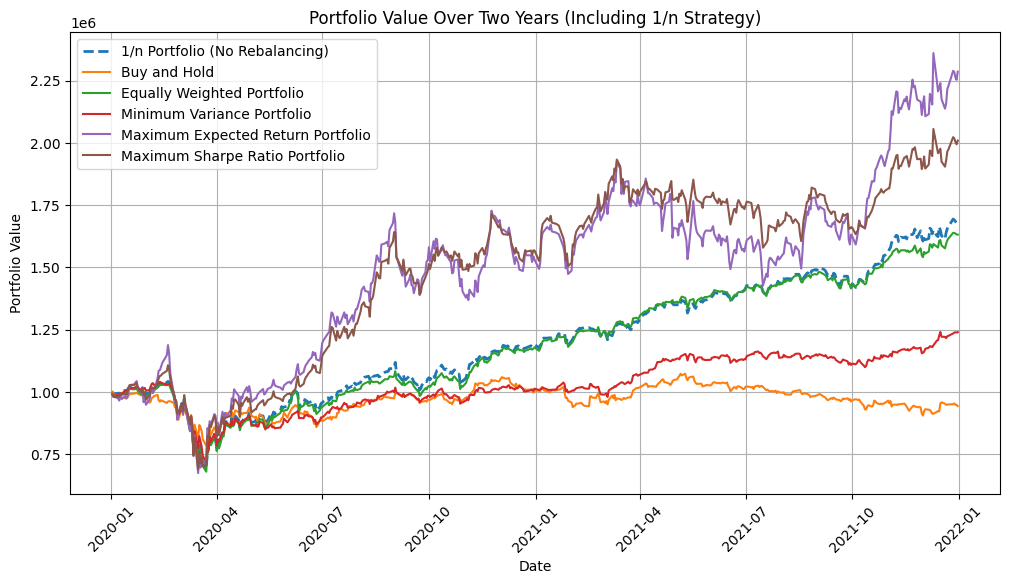

In [74]:
num_assets = data_prices.shape[1]

# 1/n Portfolio calculated at Period 1, no change afterwards
init_value = np.sum(init_positions * data_prices[0, :])
equal_weight = 1 / num_assets
x_1_n = np.floor((equal_weight * init_value) / data_prices[0, :])
cash_1_n = init_value - np.sum(x_1_n * data_prices[0, :])

portf_value_1_n = np.zeros(N_days)

# calculate portfolio value for everyday
for t in range(N_days):
    portf_value_1_n[t] = np.sum(x_1_n * data_prices[t, :]) + cash_1_n

# plot the graph of new strategy vs. others
plt.figure(figsize=(12, 6))
plt.plot(dates, portf_value_1_n, label="1/n Portfolio (No Rebalancing)", linewidth=2, linestyle="--")

for i, strategy in enumerate(strategy_names):
    plt.plot(dates, portf_value[i], label=strategy)

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Two Years (Including 1/n Strategy)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Repeat for years 2023-2024

In [75]:
# Input file
input_file_prices_new='adjclose_2023_2024.csv' # path to close_2023_2024 file

# Read data into a dataframe
df_new = pd.read_csv(input_file_prices_new)

# Initial positions in the portfolio
init_positions_new = np.array([0, 0, 0, 0, 0, 0, 0, 3542, 0, 0, 0, 10904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Annual risk-free rate for years 2023-2024 is 4.5%
r_rf2023_2024 = 0.045


In [76]:
def strat_max_return(x_init, cash_init, mu, Q, cur_prices, sector_indices):

    n = len(cur_prices)
    transaction_cost_rate = 0.005

    # annualized mu and adjusted
    mu_annualized = (1 + mu) ** 252 - 1
    mu_adjusted = mu_annualized - 0.015
    mu_adjusted = mu_adjusted / np.max(np.abs(mu_adjusted))

    # initialize cplex
    problem = cplex.Cplex()
    problem.set_problem_type(cplex.Cplex.problem_type.LP)  # linear programming
    problem.set_log_stream(None)
    problem.set_error_stream(None)
    problem.set_warning_stream(None)
    problem.set_results_stream(None)

    w_names = [f"w_{i}" for i in range(n)]
    problem.variables.add(names=w_names, types=['C'] * n, lb=[0] * n, ub=[1] * n)

    # target function: maximize w^T mu_adjusted
    objective_coeffs = mu_adjusted.tolist()
    problem.objective.set_linear(list(zip(w_names, objective_coeffs)))
    problem.objective.set_sense(problem.objective.sense.maximize)

    # weights sum to 1
    problem.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=w_names, val=[1.0] * n)],
        senses=["E"],
        rhs=[1.0]
    )

    # **NEW: 约束 2：行业多元化，确保每个行业权重 ≤ 25%**
    for sector, indices in sector_indices.items():
        sector_w_names = [w_names[i] for i in indices]  ### NEW: 获取属于该行业的股票权重变量
        sector_weights = [1.0] * len(indices)

        problem.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind=sector_w_names, val=sector_weights)],
            senses=["L"],
            rhs=[0.25]  ### NEW: 限制行业总权重 ≤ 25%
        )


    problem.solve()

    w_optimal = np.array([problem.solution.get_values(w) for w in w_names])

    # w_optimal in acceptable range
    w_optimal = np.clip(w_optimal, 0, 1)

    # calculate portfolio value and target x value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    x_target = np.maximum(1, np.floor((w_optimal * portfolio_value) / cur_prices))

    # transaction cost
    delta_x = x_target - x_init
    buy_value = np.sum(delta_x[delta_x > 0] * cur_prices[delta_x > 0])
    sell_value = np.sum(np.abs(delta_x[delta_x < 0]) * cur_prices[delta_x < 0])

    # transaction cost and cash account
    transaction_cost = buy_value * transaction_cost_rate + sell_value * transaction_cost_rate
    cash_optimal = cash_init + sell_value - buy_value - transaction_cost

    # make sur no negative cash
    while cash_optimal < 0 and np.any(delta_x > 0):
        max_buy_index = np.argmax(delta_x * cur_prices)
        if delta_x[max_buy_index] > 0:
            delta_x[max_buy_index] -= 1
            buy_value -= cur_prices[max_buy_index]
            transaction_cost -= cur_prices[max_buy_index] * transaction_cost_rate
            cash_optimal = cash_init + sell_value - buy_value - transaction_cost
        else:
            break

    x_optimal = x_init + delta_x
    return x_optimal, cash_optimal


In [77]:
# find and filter the dates
df_new['Date'] = pd.to_datetime(df_new['Date'], errors='coerce')
df_new = df_new[df_new['Date'].dt.year >= 2023]
dates_new = df_new['Date'].to_numpy()
data_prices_new = df_new.iloc[:, 1:].to_numpy()

# stock names
stock_names_new = list(df_new.columns[1:])

init_positions_new = np.zeros(len(stock_names_new))
init_value_new = 0

# HOG and CVX holding
if "HOG" in stock_names_new:
    hog_index = stock_names_new.index("HOG")
    init_positions_new[hog_index] = 10904
    init_value_new += 10904 * data_prices_new[0, hog_index]

if "CVX" in stock_names_new:
    cvx_index = stock_names_new.index("CVX")
    init_positions_new[cvx_index] = 3542
    init_value_new += 3542 * data_prices_new[0, cvx_index]

print(f"Initial Portfolio Value (2023-2024): ${init_value_new:.2f}")

# same loop as previous
N_strat = 5
N_days = len(dates_new)
N_periods = 12
portf_value_new = [np.zeros(N_days) for _ in range(N_strat)]
x_new = np.empty((N_strat, N_periods), dtype=object)
cash_new = np.zeros((N_strat, N_periods))

# every periods
for period in range(1, N_periods + 1):
    cur_year = 2023 + (period - 1) // 6
    cur_month = 1 + ((period - 1) % 6) * 2

    next_year, next_month = cur_year, cur_month + 1
    if next_month > 12:
        next_year += 1
        next_month = 1

    valid_days_start = np.where((df_new['Date'].dt.year == cur_year) & (df_new['Date'].dt.month == cur_month))[0]
    valid_days_end = np.where((df_new['Date'].dt.year == next_year) & (df_new['Date'].dt.month == next_month))[0]

    if len(valid_days_start) == 0 or len(valid_days_end) == 0:
        print(f"Skipping period {period} due to missing trading days.")
        continue

    day_ind_start = valid_days_start[0]
    day_ind_end = valid_days_end[-1]

    print(f"\nPeriod {period}: start date {dates_new[day_ind_start]}, end date {dates_new[day_ind_end]}")

    cur_prices = data_prices_new[day_ind_start, :]

    # every strategies
    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions_new.copy()
            curr_cash = 0.0
        else:
            curr_positions = x_new[strategy, period - 2].copy()
            curr_cash = float(cash_new[strategy, period - 2])

        x_new[strategy, period - 1], cash_new[strategy, period - 1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        p_values = np.dot(data_prices_new[day_ind_start:day_ind_end + 1, :], x_new[strategy, period - 1]) + cash_new[strategy, period - 1]
        portf_value_new[strategy][day_ind_start:day_ind_end + 1] = np.ravel(p_values)

        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(
            strategy_names[strategy],
            portf_value_new[strategy][day_ind_start],
            portf_value_new[strategy][day_ind_end],
            cash_new[strategy, period - 1]
        ))

    cur_returns = data_prices_new[day_ind_start + 1:day_ind_end + 1, :] / data_prices_new[day_ind_start:day_ind_end, :] - 1
    mu = np.mean(cur_returns, axis=0)
    Q = np.cov(cur_returns.T)


Initial Portfolio Value (2023-2024): $1000013.01

Period 1: start date 2023-01-03T00:00:00.000000000, end date 2023-02-28T00:00:00.000000000
  Strategy "Buy and Hold", value begin = $ 1000013.01, value end = $ 1028941.58, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990725.25, value end = $ 1020891.75, cash account = $96.47
  Strategy "Minimum Variance Portfolio", value begin = $ 990126.90, value end = $ 984329.89, cash account = $0.07
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990064.75, value end = $ 791395.21, cash account = $26.29
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 989962.38, value end = $ 882153.07, cash account = $112.87

Period 2: start date 2023-03-01T00:00:00.000000000, end date 2023-04-28T00:00:00.000000000
  Strategy "Buy and Hold", value begin = $ 1032531.25, value end = $ 946375.95, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 1014492.14, value end = $ 1060478.9

# Plot the results for years 2023-2024

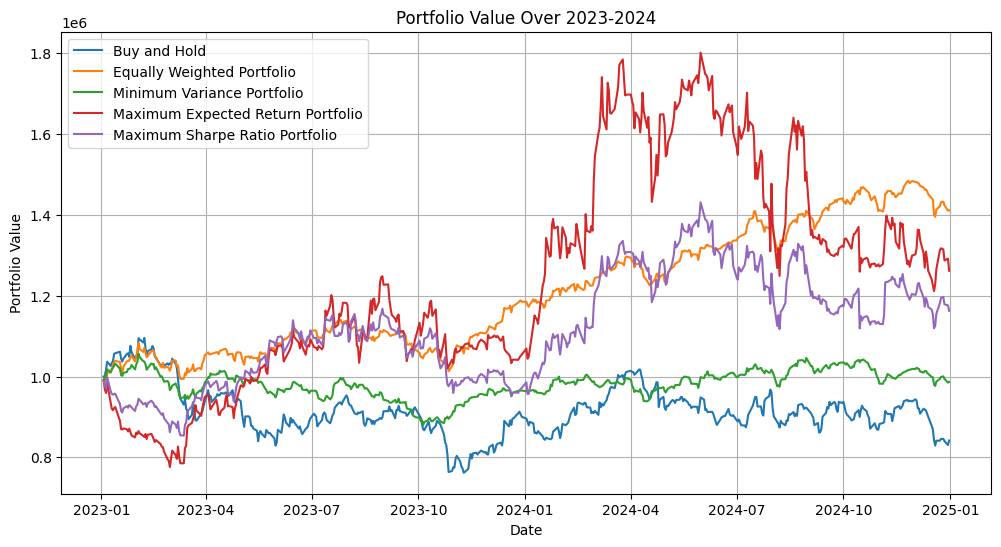

In [78]:
# plot the graph for 2023-2024
plt.figure(figsize=(12, 6))
for strategy in range(N_strat):
    plt.plot(dates_new, portf_value_new[strategy], label=strategy_names[strategy])

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over 2023-2024")
plt.legend()
plt.grid(True)
plt.show()
